In [1]:
import time
import pandas as pd

from src.colocation_miner import ColocationMiner

## OSM Points of Interest

In [2]:
from math import sin, sqrt, asin, radians, cos
from typing import List, Tuple


def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 
    return c * r

def calculate_area(bounding_box: Tuple[float, float, float, float]) -> float:
    """
    Calculate approximate area of a bounding box in square kilometers.
    
    Args:
        bounding_box: Tuple of (min_lat, min_lon, max_lat, max_lon)
        
    Returns:
        Area in square kilometers
    """
    min_lat, min_lon, max_lat, max_lon = bounding_box
    
    mid_lat = (min_lat + max_lat) / 2
    width = haversine_distance(mid_lat, min_lon, mid_lat, max_lon)
    height = haversine_distance(min_lat, min_lon, max_lat, min_lon)
    
    return width * height

In [3]:
cities = {
    "Warsaw": {
        "bounding_box": (52.15, 20.85, 52.35, 21.15),
        "color": "blue"
    },
    "Paris": {
        "bounding_box": (48.80, 2.25, 48.95, 2.45),
        "color": "red"
    },
    "New York": {
        "bounding_box": (40.65, -74.05, 40.85, -73.85),
        "color": "green"
    },
    "Tokyo": {
        "bounding_box": (35.60, 139.60, 35.80, 139.80),
        "color": "purple"
    }
}

In [4]:
for city_name, city_data in cities.items():
    area = calculate_area(city_data["bounding_box"])
    city_data["area_km2"] = area

In [5]:
cities

{'Warsaw': {'bounding_box': (52.15, 20.85, 52.35, 21.15),
  'color': 'blue',
  'area_km2': 454.1783927719344},
 'Paris': {'bounding_box': (48.8, 2.25, 48.95, 2.45),
  'color': 'red',
  'area_km2': 243.96164309229803},
 'New York': {'bounding_box': (40.65, -74.05, 40.85, -73.85),
  'color': 'green',
  'area_km2': 374.67070329399024},
 'Tokyo': {'bounding_box': (35.6, 139.6, 35.8, 139.8),
  'color': 'purple',
  'area_km2': 401.63408505539417}}

In [6]:
gastronomy = [
    "bar", "biergarten", "cafe", "fast_food", "food_court", 
    "ice_cream", "pub", "restaurant"
]

education = [
    "college", "dancing_school", "driving_school", "first_aid_school",
    "kindergarten", "language_school", "library", "surf_school", 
    "toy_library", "research_institute", "training", "music_school",
    "school", "traffic_park", "university"
]

transport = [
    "bicycle_parking", "bicycle_repair_station", "bicycle_rental", 
    "bicycle_wash", "boat_rental", "boat_sharing", "bus_station",
    "car_rental", "car_sharing", "car_wash", "compressed_air",
    "vehicle_inspection", "charging_station", "driver_training",
    "ferry_terminal", "fuel", "grit_bin", "motorcycle_parking",
    "parking", "parking_entrance", "parking_space", "taxi", "weighbridge"
]

finance = [
    "atm", "payment_terminal", "bank", "bureau_de_change", 
    "money_transfer", "payment_centre"
]

healthcare = [
    "baby_hatch", "clinic", "dentist", "doctors", "hospital",
    "nursing_home", "pharmacy", "social_facility", "veterinary"
]

entertainment = [
    "arts_centre", "brothel", "casino", "cinema", "community_centre",
    "conference_centre", "events_venue", "exhibition_centre", "fountain",
    "gambling", "love_hotel", "music_venue", "nightclub", "planetarium",
    "public_bookcase", "social_centre", "stage", "stripclub", "studio",
    "swingerclub", "theatre"
]

public_service = [
    "courthouse", "fire_station", "police", "post_box", "post_depot",
    "post_office", "prison", "ranger_station", "townhall"
]

facilities = [
    "bbq", "bench", "dog_toilet", "dressing_room", "drinking_water",
    "give_box", "lounge", "mailroom", "parcel_locker", "shelter", 
    "shower", "telephone", "toilets", "water_point", "watering_place"
]

waste_management = [
    "sanitary_dump_station", "recycling", "waste_basket", 
    "waste_disposal", "waste_transfer_station"
]

other = [
    "animal_boarding", "animal_breeding", "animal_shelter", "animal_training",
    "baking_oven", "clock", "crematorium", "dive_centre", "funeral_hall",
    "grave_yard", "hunting_stand", "internet_cafe", "kitchen", 
    "kneipp_water_cure", "lounger", "marketplace", "monastery", 
    "mortuary", "photo_booth", "place_of_mourning", "place_of_worship",
    "public_bath", "public_building", "refugee_site", "vending_machine"
]

all = gastronomy + education + transport + finance + healthcare + \
    entertainment + public_service + facilities + waste_management + other

subset = gastronomy + education + transport + finance

In [7]:
len(all), len(subset)

(136, 52)

In [8]:
from src.colocation_dataset import OSMColocationDataset


def get_colocations_for_area(
    poi_types: List[str],
    bounding_box: Tuple[float, float, float, float],
    radius: float = 0.005,
    min_prevalence: float = 0.3,
) -> Tuple[int, float]:
    """
    Get colocations for a specific area defined by the bounding box.
    
    Args:
        poi_types: List of POI types to consider.
        bounding_box: Tuple of (min_lat, min_lon, max_lat, max_lon).
        radius: Radius for colocation search in degrees.
        min_prevalence: Minimum prevalence for colocation.
        
    Returns:
        Tuple of (number of colocations, execution time).
    """
    dataset = OSMColocationDataset(
        poi_types=poi_types,
        area=bounding_box,
    )
    data = dataset.load_data()
    print(f"Loaded {len(data)} POIs from the dataset.")
    
    miner = ColocationMiner(
        radius=radius,
        min_prevalence=min_prevalence,
    )

    start_time = time.time()
    miner.fit(data)
    total_time = time.time() - start_time
    
    print(f"Total time taken: {total_time:.2f} seconds")

    patterns = miner.get_patterns()
    patterns_df = pd.DataFrame([p.to_dict() for p in patterns])

    print(f"Number of colocations found: {len(patterns)}")

    if len(patterns) > 0:
        print("\nTop patterns:")
        pd.set_option('display.max_colwidth', None)
        print(patterns_df.head(10))

    return len(patterns), total_time

In [9]:
import matplotlib.pyplot as plt
import time
from typing import Dict, List

def run_experiments(
    cities_data: Dict[str, object], 
    city_name: str,
    poi_types: List[str],
    radiuses: List[float] = [0.001, 0.002, 0.003],
    min_prevalences: List[float] = [0.3, 0.5, 0.7, 0.9],
) -> None:
    """
    Run experiments for a specific city.
    
    Args:
        cities_data: Dictionary containing data for all cities.
        city_name: Name of the city.
        poi_types: List of POI types to consider.
        radiuses: List of radii to evaluate.
        min_prevalences: List of minimum prevalence thresholds.
    """
    city_data = cities_data[city_name]
    bounding_box = city_data["bounding_box"]
    area = city_data["area_km2"]

    times_per_radius = {}
    
    for radius in radiuses:
        print(f"\n=== Running experiments for {city_name} ({area:.2f} km²) with radius: {radius} degrees=== ")
        times_per_radius[radius] = {}
        colocations, exec_times = [], []
        for min_prevalence in min_prevalences:
            num_colocations, exec_time = get_colocations_for_area(
                poi_types,
                bounding_box,
                radius=radius,
                min_prevalence=min_prevalence,
            )
            colocations.append(num_colocations)
            exec_times.append(exec_time)
            print(f"=== Radius: {radius}, Min Prevalence: {min_prevalence}, "
                  f"Colocations: {num_colocations}, Time: {exec_time:.2f} seconds ===")
            times_per_radius[radius][min_prevalence] = {
                "colocations": num_colocations,
                "exec_time": exec_time,
            }

        fig, ax1 = plt.subplots()
        color1 = "tab:red"
        ax1.set_xlabel("Min Prevalence")
        ax1.set_ylabel("Colocations", color=color1)
        ax1.plot(min_prevalences, colocations, color=color1)
        ax1.tick_params(axis='y', labelcolor=color1)
        ax1.set_xticks(min_prevalences)
        ax1.grid(True)
        ax1.set_title(f"{city_name} - Radius: {radius}")

        ax2 = ax1.twinx()
        color2 = "tab:blue"
        ax2.set_ylabel("Execution Time (seconds)", color=color2)
        ax2.plot(min_prevalences, exec_times, color=color2)
        ax2.tick_params(axis='y', labelcolor=color2)
        
        fig.tight_layout()
        timestamp = time.strftime("%Y%m%d-%H%M%S")
        plt.savefig(f"imgs/{city_name.lower()}_radius_{radius}_{timestamp}.png")
        plt.show()

    for min_prevalence in min_prevalences:
        exec_times_by_radius = []
        for radius in radiuses:
            exec_time = times_per_radius[radius][min_prevalence]["exec_time"]
            exec_times_by_radius.append(exec_time)
        
        plt.figure()
        plt.plot(radiuses, exec_times_by_radius, marker='o')
        plt.title(f"{city_name} - Execution Time vs Radius (Min Prevalence: {min_prevalence})")
        plt.xlabel("Radius")
        plt.ylabel("Execution Time (seconds)")
        plt.grid(True)
        plt.savefig(f"imgs/{city_name.lower()}_exec_time_vs_radius_prevalence_{min_prevalence}_{timestamp}.png")
        plt.show()



=== Running experiments for Warsaw (454.18 km²) with radius: 0.004 degrees=== 
Loaded 49600 POIs from the dataset.
Data preparation completed in 0.20 seconds
Spatial indices built in 0.05 seconds
Neighbor precomputation completed in 17.25 seconds
Found 49 patterns of size 2 in 25.70 seconds
Processing patterns of length: 3
Found 76 candidates

Multi-resolution pruning setup:
  Grid size: 0.008
  Total coarse instances: 8797
  Avg compression ratio: 5.6:1
  Pruned: ('cafe', 'restaurant', 'vending_machine') (coarse PI=0.695)
  Pruned: ('dentist', 'restaurant', 'vending_machine') (coarse PI=0.695)
  Pruned: ('dentist', 'fast_food', 'vending_machine') (coarse PI=0.695)
  Pruned: ('cafe', 'dentist', 'vending_machine') (coarse PI=0.642)
  Pruned: ('atm', 'cafe', 'vending_machine') (coarse PI=0.690)

Multi-resolution pruning results:
  Candidates evaluated: 76
  Candidates pruned: 8
  Candidates remaining: 68
  Pruning rate: 10.5%
  Time elapsed: 3.76 seconds
After pruning: 68 candidates rem

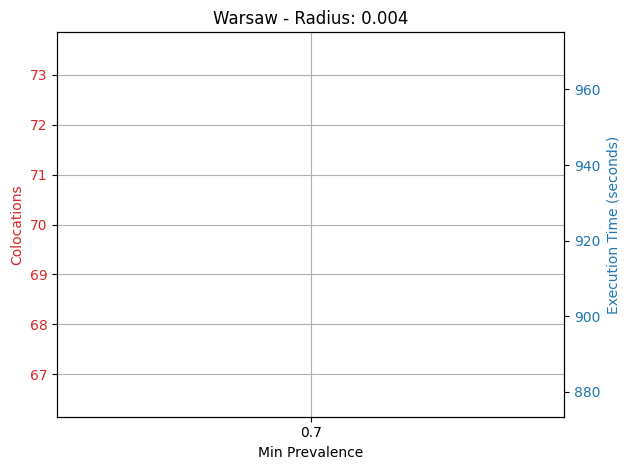

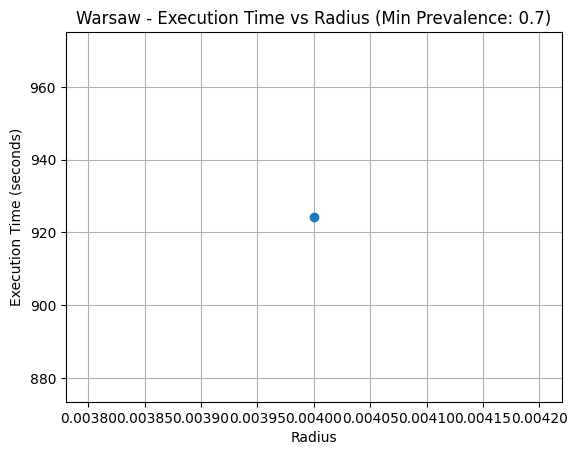

In [11]:
run_experiments(cities, "Warsaw", poi_types=all, radiuses=[0.004], min_prevalences=[0.7]) # [0.001, 0.002, 0.003]

City: Paris, Area: 243.96 km²
Loaded 46317 POIs from the dataset.
Data preparation completed in 0.26 seconds
Spatial indices built in 0.03 seconds
Neighbor precomputation completed in 8.25 seconds
Found 75 patterns of size 2 in 5.61 seconds
Processing patterns of length: 3
Found 211 candidates
After pruning: 211 candidates remain
Found 108 frequent patterns in 43.00 seconds
Processing patterns of length: 4
Found 112 candidates
After pruning: 112 candidates remain
Found 89 frequent patterns in 154.58 seconds
Processing patterns of length: 5
Found 52 candidates
After pruning: 52 candidates remain
Found 40 frequent patterns in 421.27 seconds
Processing patterns of length: 6
Found 4 candidates
After pruning: 4 candidates remain
Found 3 frequent patterns in 403.38 seconds
Processing patterns of length: 7
Found 0 candidates
Total time taken: 1036.40 seconds
Number of colocations found: 315

Top patterns:
                               types  participation_index  num_instances
0      (bicycle

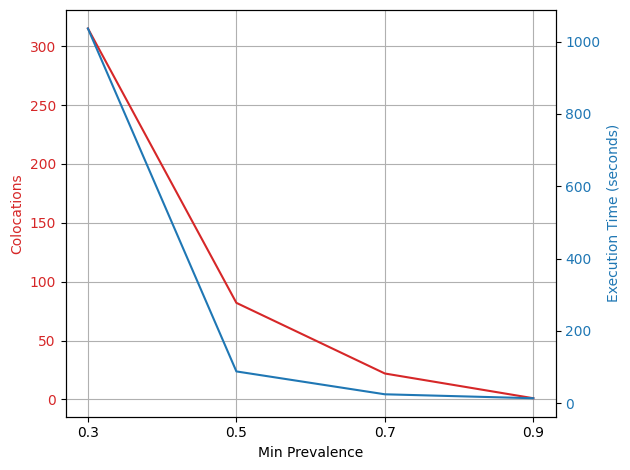

Loaded 46317 POIs from the dataset.
Data preparation completed in 0.10 seconds
Spatial indices built in 0.03 seconds
Neighbor precomputation completed in 9.19 seconds
Found 159 patterns of size 2 in 11.93 seconds
Processing patterns of length: 3
Found 749 candidates
After pruning: 749 candidates remain
Found 434 frequent patterns in 376.05 seconds
Processing patterns of length: 4
Found 820 candidates
After pruning: 820 candidates remain


KeyboardInterrupt: 

In [ ]:
run_experiments(cities, "Paris", poi_types=subset, radiuses=[0.001, 0.0015, 0.002])

## GBIF

In [30]:
from src.colocation_dataset import GBIFColocationDataset

In [ ]:
poland_bbox = (49.0, 14.1, 55.0, 24.2)

poland_species = [
    "Quercus robur",         # Oak tree
    "Fomes fomentarius",     # Tinder fungus
    "Dendrocopos major",     # Great spotted woodpecker
    "Sciurus vulgaris",      # Red squirrel
    "Dactylis glomerata",    # Cock's-foot grass
    "Apis mellifera",        # Honey bee
    "Papilio machaon",       # Swallowtail butterfly
    "Phragmites australis",  # Common reed
    "Ardea cinerea",         # Grey heron
    "Esox lucius",           # Northern pike
    "Canis lupus",           # Gray wolf
    "Ursus arctos",          # Brown bear
    "Cervus elaphus",        # Red deer
]

gbif_dataset = GBIFColocationDataset(
    area=poland_bbox,
    species_names=poland_species,
    limit_per_species=10000, 
    min_year=2020,
)

df = gbif_dataset.load_data()

print(f"\nLoaded {len(df)} total occurrence records")
print("\nSample of data:")
print(df.head())
print("\nOccurrences per species:")
print(df['type'].value_counts())


Processing species: Quercus robur
Found species key: 2878688
Found 2062 records for Quercus robur
Retrieved 2062 occurrences

Processing species: Fomes fomentarius
Found species key: 8068867
Found 1140 records for Fomes fomentarius
Retrieved 1140 occurrences

Processing species: Dendrocopos major
Found species key: 2477968
Found 70080 records for Dendrocopos major
Retrieved 10000 occurrences

Processing species: Sciurus vulgaris
Found species key: 8211070
Found 2958 records for Sciurus vulgaris
Retrieved 2958 occurrences

Processing species: Dactylis glomerata
Found species key: 2705308
Found 3812 records for Dactylis glomerata
Retrieved 3812 occurrences

Processing species: Apis mellifera
Found species key: 1341976
Found 20538 records for Apis mellifera
Retrieved 10000 occurrences

Processing species: Papilio machaon
Found species key: 8225376
Found 1020 records for Papilio machaon
Retrieved 1020 occurrences

Processing species: Phragmites australis
Found species key: 5290149
Found 2

In [35]:
miner = ColocationMiner(radius=0.05, min_prevalence=0.6)
miner.fit(df)

patterns = miner.get_patterns()
print(f"Found {len(patterns)} colocation patterns")
patterns_df = pd.DataFrame([p.to_dict() for p in patterns])

Data preparation completed in 0.03 seconds
Spatial indices built in 0.01 seconds
Neighbor precomputation completed in 2.20 seconds
Found 5 patterns of size 2 in 1.81 seconds
Processing patterns of length: 3
Found 1 candidates
After pruning: 1 candidates remain
Found 0 frequent patterns in 0.95 seconds
Found 5 colocation patterns


In [34]:
patterns_df.head(10)

,types,participation_index,num_instances
0,"(Ardea cinerea, Dendrocopos major)",0.869800,354670
1,"(Dactylis glomerata, Quercus robur)",0.680407,27764
2,"(Phragmites australis, Quercus robur)",0.666033,12933
3,"(Dactylis glomerata, Phragmites australis)",0.665652,23588
4,"(Apis mellifera, Fomes fomentarius)",0.610526,14897


|  # | Scientific Names                           | English Names                          | Polish Names                            | Score    | Count  |
| -: | ------------------------------------------ | -------------------------------------- | --------------------------------------- | -------- | ------ |
|  0 | (Ardea cinerea, Dendrocopos major)         | (Grey heron, Great spotted woodpecker) | (Czapla siwa, Dzięcioł duży)            | 0.869800 | 354670 |
|  1 | (Dactylis glomerata, Quercus robur)        | (Orchard grass, English oak)           | (Kupkówka pospolita, Dąb szypułkowy)    | 0.680407 | 27764  |
|  2 | (Phragmites australis, Quercus robur)      | (Common reed, English oak)             | (Trzcina pospolita, Dąb szypułkowy)     | 0.666033 | 12933  |
|  3 | (Dactylis glomerata, Phragmites australis) | (Orchard grass, Common reed)           | (Kupkówka pospolita, Trzcina pospolita) | 0.665652 | 23588  |
|  4 | (Apis mellifera, Fomes fomentarius)        | (Western honey bee, Tinder fungus)     | (Pszczoła miodna, Hubiak pospolity)     | 0.610526 | 14897  |
